## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
# using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
#=
import LossFunctions: HuberLoss, value
import Distributions: Chisq, ccdf
import StatsBase: mad, sample

function huberize(y::Vector{Float64})
    m = median(y)
    s = mad(y,normalize=true)
    z = (y.-m)./s
    l = value.(HuberLoss(1),z)
    x = sign.(z).* sqrt.(2*l)
    return m .+ s.*x
end
=#

## Load processed_data:

### By individuals:

In [5]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [6]:
BXD_pheno_ind_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [7]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [8]:
BXD_geno_ind_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [9]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### By strains:

In [10]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [11]:
BXD_pheno_strains_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [12]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


In [13]:
BXD_geno_strains_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [14]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load functions:

In [15]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [16]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [17]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [18]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [19]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [20]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [21]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000238 seconds (76 allocations: 503.766 KiB)


Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [22]:
round.(kinship_ind_from_strains[1:10, 1:10], digits = 2)

10×10 Matrix{Float64}:
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 0.55  0.55  0.55  0.55  1.0   0.56  0.56  0.56  0.56  0.56
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0

In [23]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [24]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  3.245601 seconds (306.28 k allocations: 8.368 GiB, 6.14% gc time)


In [25]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 29437-th livear proteomic as the single trait to run analysis:  

In [26]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [27]:
lp_id = 29437;
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

In [28]:
prior = [1.0, 0.1];

#### For individual liver proteome

In [29]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [30]:
lpst_ind_Y = colStandardize(lp_ind_Y);
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);

Loglik plot: 


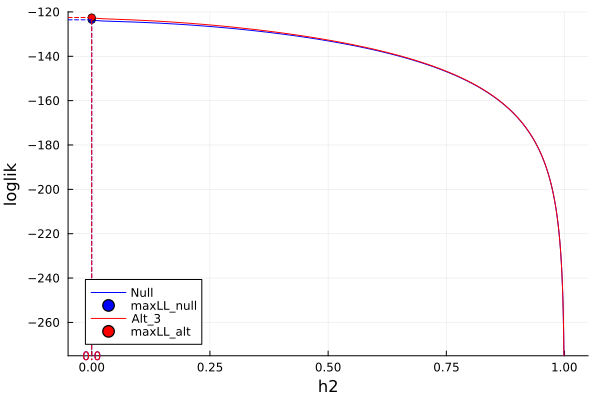

 26.346688 seconds (71.55 M allocations: 4.054 GiB, 3.91% gc time, 98.69% compilation time)


In [31]:
@time scan_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                              prior_variance = prior[1], prior_sample_size = prior[2],
                              plot_loglik = true, markerID = 3, h2_grid = collect(0.0:999).*0.001,
                              x_lims = [0.0, 1.0], y_lims = [-275, -120.0]);

In [32]:
BLAS.set_num_threads(Threads.nthreads())

In [33]:
BLAS.get_num_threads()

16

In [34]:
@time scan_results_ind_alt = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt", 
                                  prior_variance = prior[1], prior_sample_size = prior[2]);

 14.159934 seconds (11.82 M allocations: 14.368 GiB, 11.21% gc time, 0.25% compilation time)


In [35]:
@time scan_perms_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                    prior_variance = prior[1], prior_sample_size = prior[2],
                                    permutation_test = true, nperms = 1000, original = true);

  1.010721 seconds (2.04 M allocations: 268.273 MiB, 2.44% gc time, 87.71% compilation time)


In [36]:
max_lods = vec(mapslices(x -> maximum(x), scan_perms_results_ind; dims = 1));

In [37]:
thrs = map(x -> quantile(max_lods, x), [0.85, 0.95]);

In [38]:
lp_id

29437

In [39]:
mean(scan_perms_results_ind[:, 1] .> 2.94)

0.0

In [40]:
thrs

2-element Vector{Float64}:
 2.896638126422173
 3.4268718725428533

In [41]:
single_results_ind = DataFrame(hcat(scan_results_ind.lod, scan_results_ind_alt.lod, scan_perms_results_ind[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

In [42]:
single_results_ind[1:6, :]

Row,scan_null,scan_alt,scan_perms.original
,Float64,Float64,Float64
1,0.44861,0.448609,0.44861
2,0.44861,0.448609,0.44861
3,0.44861,0.448609,0.44861
4,0.44861,0.448609,0.44861
5,0.44861,0.448609,0.44861
6,0.44861,0.448609,0.44861


#### For liver proteome means by strains

In [43]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [44]:
lpst_strains_Y = colStandardize(lp_strains_Y);
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

In [45]:
@time scan_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains; 
                                  prior_variance = prior[1], prior_sample_size = prior[2],
                                  optim_interval = 4);

  0.088418 seconds (206.24 k allocations: 40.237 MiB, 36.48% compilation time)


In [46]:
@time scan_results_strains_alt = scan(lpst_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt",
                                      prior_variance = prior[1], prior_sample_size = prior[2]);

  1.632704 seconds (4.08 M allocations: 1.233 GiB, 10.05% gc time)


In [47]:
@time scan_perms_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true, 
                                        prior_variance = prior[1], prior_sample_size = prior[2]);

  0.071453 seconds (214.75 k allocations: 85.974 MiB, 46.61% compilation time)


In [48]:
single_results_strains = DataFrame(hcat(scan_results_strains.lod, scan_results_strains_alt.lod, scan_perms_results_strains[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

In [49]:
single_results_strains[1:6, :]

Row,scan_null,scan_alt,scan_perms.original
,Float64,Float64,Float64
1,0.147528,0.359619,0.363103
2,0.147528,0.359619,0.363103
3,0.147528,0.359619,0.363103
4,0.147528,0.359619,0.363103
5,0.147528,0.359619,0.363103
6,0.147528,0.359619,0.363103


In [50]:
size(lp_strains_y)

(50, 1)

In [51]:
lpst_strains_y[1:5]./sqrt(0.5)

5-element Vector{Float64}:
  1.0226201850024244
 -0.007395742683977131
  0.8020068444624721
  1.234467432540759
 -0.5639098286938068

### Weighted Error Variances:

Assuming that

$$y = X_0 B_0+g\beta+\epsilon$$

where 

$$\epsilon \sim N(0,  \sigma^2_g K + \sigma^2_e V) $$ and 

the matrix $V$ is a diagonal but not necessarily an identity matrix.

Notice that since $V^{-1} = V^{-1/2}V^{-1/2}$, then the strategy is as such:

Let $$y^* = V^{-1/2}y = V^{-1/2}X0+V^{-1/2}g\beta+V^{-1/2}\epsilon$$

then 
$$V^{-1/2}\epsilon \sim N(0, \sigma^2_g V^{-1/2}KV^{-1/2}+\sigma^2_e V^{-1/2}VV^{-1/2} = \sigma^2_g K^*+\sigma^2_e I)$$

In [52]:
BXD_pheno_ind_summary_df[1:6, :]

Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_GRDCGDEVAQWFTNYLK_3,Q99M02_SIYQSSPLFGMYFSVEK_2,Q99M02_RQLQQVGTVSK_3,Q99M02_LYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_5,Q99M02_SIYQSSPLFGMYFSVEK_3,Q99M02_CVLTTVDPDTGIIDRK_3,Q99M02_CVLTTVDPDTGIIDR_3,Q99M02_TQAYRLVQFDTSMK_3,Q99M02_GVSVCETECTDMGLR_2,Q99M02_DCGDEVAQWFTNYLK_2,Q99M02_DRFWMVVK_2,Q99M02_GRDCGDEVAQWFTNYLK_2,Q99M02_DCGDEVAQWFTNYLK_3,Q99M02_EDGHMVTAR_2,Q99M02_RQLQQVGTVSK_2,P42208_TIISYIDEQFER_2,P42208_ILDEIEEHSIK_3,P42208_VNIVPVIAK_2,P42208_ASIPFSVVGSNQLIEAK_2,P42208_TVQIEASTVEIEER_2,P42208_LTVVDTPGYGDAINCR_2,P42208_ASIPFSVVGSNQLIEAK_3,P42208_STLINSLFLTDLYPER_3,Q9Z1S5_VNIIPVIAK_2,Q3KNM2_LGPVVYVLDLADR_2,Q9Z2Q6_LATPEDKQDIDKQYVGFATLPNQVHR_4,Q9Z2Q6_VNIVPILAK_2,Q9R1T4_RNEFLGELQK_3,Q9R1T4_STLMDTLFNTK_2,O55131_STLINSLFLTDLYSPEYPGPSHR_3,O55131_FEDYLNAESR_2,O55131_IYEFPETDDEEENKLVK_3,O55131_NLEGYVGFANLPNQVYR_2,O55131_DVTNNVHYENYR_3,O55131_ANWEAQQR_2,O55131_NLEGYVGFANLPNQVYR_3,O55131_ADTLTPEECQQFK_2,O55131_ILEQQNSSR_2,O55131_VQCCLYFIAPSGHGLKPLDIEFMK_4,O55131_TVQVEQSK_2,O55131_LKDSEAELQR_2,Q8CHH9_VNIIPLIAK_2,Q8CHH9_VNIIPIIAK_2,Q80UG5_ADTLTLEER_2,Q80UG5_STLINTLFK_2,Q80UG5_RTEITIVKPQESVLR_4,Q80UG5_DITSNIHFEAYR_3,Q80UG5_LEPRPSVAEVPYR_3,Q80UG5_FINDQYEK_2,Q80UG5_YLQEEVNINR_2,Q80UG5_VVNIVPVIAK_2,Q80UG5_SITHDIEEK_2,Q80UG5_IPEGSAVPATDAAPK_2,Q80UG5_SVQPTSEER_2,Q80UG5_QVESTASAAGPSR_2,Q8C1B7_FESDPATHNEPGVR_3,Q8C1B7_SYELQESNVR_2,Q8C1B7_NLSLSGHVGFDSLPDQLVNK_3,Q8C1B7_AAAQLLQSQAQQSGAQQTK_3,Q8C1B7_ELEEEVSNFQK_2,Q9ERR7_WNTDSVEEFLSEK_2,Q9ERR7_LLDDNGNIAEELSILK_2,Q9ERY9_YLEAEPVSR_2,P59708_ITAEEMYDIFGK_2,Q9DCS2_CLDSIAATTR_2,Q9DCS2_ISPQSNVDFDLTLR_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_4,Q9DCS2_QYVDPAQR_2,Q9DCS2_NKEPILSVLR_2,Q9DCS2_AQGLSNVK_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_5,Q9DCS2_MVDMPANNK_2,Q9DCS2_DTVLLEELGQASGLVLER_3,Q9DCS2_DTVLLEELGQASGLVLER_2,Q9JHJ3_LLHTADVCQLEVALVGASPR_3,A2A8E1_TIVEFECR_2,A2A8E1_ATLENVTNLRPVGEDFR_3,A2A8E1_ENSIDILSSTIK_2,A2A8E1_AQESVGIFEVTHQFVK_3,Q8BWR2_GLAYGLYLR_2,Q8VED9_IQTLSAIDTIK_2,Q9CRB3_LFFDTER_2,Q9CRB3_FHVPLLLSPWSYTTYR_3,Q9CRB3_TSYTNLDGR_2,Q9CRB3_LEAPCQQWMELR_2,Q9CRB3_CPGLLTPSQIKPGTYK_3,Q9CRB3_LEAPCQQWMELR_3,⋯
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323,16.263,16.24,16.052,15.355,15.795,15.4,15.03,14.831,14.914,14.755,14.389,14.272,13.992,14.291,13.762,13.167,12.662,10.913,14.723,14.348,13.345,14.228,13.862,13.902,13.687,11.613,10.245,14.409,15.147,12.34,14.404,13.775,14.293,14.461,14.23,14.065,14.258,14.31,13.616,13.541,13.46,13.293,12.937,12.717,15.149,14.36,14.833,14.341,14.579,14.316,14.049,13.817,13.656,13.297,13.78,12.843,12.439,11.074,14.065,13.915,13.994,13.907,13.247,13.356,12.815,14.702,13.637,16.398,16.402,16.271,16.0,15.909,15.647,15.021,13.726,7.236,3.295,13.794,14.838,14.908,14.664,13.055,12.612,13.323,18.252,16.889,17.118,16.443,15.683,14.183,⋯
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021,16.332,15.965,15.624,15.336,14.811,14.979,14.957,14.474,14.815,14.912,14.77,14.244,14.151,13.87,13.696,11.285,13.094,1

In [53]:
BXD_pheno_strains_summary_df[1:6, :]

Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_GRDCGDEVAQWFTNYLK_3,Q99M02_SIYQSSPLFGMYFSVEK_2,Q99M02_RQLQQVGTVSK_3,Q99M02_LYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_5,Q99M02_SIYQSSPLFGMYFSVEK_3,Q99M02_CVLTTVDPDTGIIDRK_3,Q99M02_CVLTTVDPDTGIIDR_3,Q99M02_TQAYRLVQFDTSMK_3,Q99M02_GVSVCETECTDMGLR_2,Q99M02_DCGDEVAQWFTNYLK_2,Q99M02_DRFWMVVK_2,Q99M02_GRDCGDEVAQWFTNYLK_2,Q99M02_DCGDEVAQWFTNYLK_3,Q99M02_EDGHMVTAR_2,Q99M02_RQLQQVGTVSK_2,P42208_TIISYIDEQFER_2,P42208_ILDEIEEHSIK_3,P42208_VNIVPVIAK_2,P42208_ASIPFSVVGSNQLIEAK_2,P42208_TVQIEASTVEIEER_2,P42208_LTVVDTPGYGDAINCR_2,P42208_ASIPFSVVGSNQLIEAK_3,P42208_STLINSLFLTDLYPER_3,Q9Z1S5_VNIIPVIAK_2,Q3KNM2_LGPVVYVLDLADR_2,Q9Z2Q6_LATPEDKQDIDKQYVGFATLPNQVHR_4,Q9Z2Q6_VNIVPILAK_2,Q9R1T4_RNEFLGELQK_3,Q9R1T4_STLMDTLFNTK_2,O55131_STLINSLFLTDLYSPEYPGPSHR_3,O55131_FEDYLNAESR_2,O55131_IYEFPETDDEEENKLVK_3,O55131_NLEGYVGFANLPNQVYR_2,O55131_DVTNNVHYENYR_3,O55131_ANWEAQQR_2,O55131_NLEGYVGFANLPNQVYR_3,O55131_ADTLTPEECQQFK_2,O55131_ILEQQNSSR_2,O55131_VQCCLYFIAPSGHGLKPLDIEFMK_4,O55131_TVQVEQSK_2,O55131_LKDSEAELQR_2,Q8CHH9_VNIIPLIAK_2,Q8CHH9_VNIIPIIAK_2,Q80UG5_ADTLTLEER_2,Q80UG5_STLINTLFK_2,Q80UG5_RTEITIVKPQESVLR_4,Q80UG5_DITSNIHFEAYR_3,Q80UG5_LEPRPSVAEVPYR_3,Q80UG5_FINDQYEK_2,Q80UG5_YLQEEVNINR_2,Q80UG5_VVNIVPVIAK_2,Q80UG5_SITHDIEEK_2,Q80UG5_IPEGSAVPATDAAPK_2,Q80UG5_SVQPTSEER_2,Q80UG5_QVESTASAAGPSR_2,Q8C1B7_FESDPATHNEPGVR_3,Q8C1B7_SYELQESNVR_2,Q8C1B7_NLSLSGHVGFDSLPDQLVNK_3,Q8C1B7_AAAQLLQSQAQQSGAQQTK_3,Q8C1B7_ELEEEVSNFQK_2,Q9ERR7_WNTDSVEEFLSEK_2,Q9ERR7_LLDDNGNIAEELSILK_2,Q9ERY9_YLEAEPVSR_2,P59708_ITAEEMYDIFGK_2,Q9DCS2_CLDSIAATTR_2,Q9DCS2_ISPQSNVDFDLTLR_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_4,Q9DCS2_QYVDPAQR_2,Q9DCS2_NKEPILSVLR_2,Q9DCS2_AQGLSNVK_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_5,Q9DCS2_MVDMPANNK_2,Q9DCS2_DTVLLEELGQASGLVLER_3,Q9DCS2_DTVLLEELGQASGLVLER_2,Q9JHJ3_LLHTADVCQLEVALVGASPR_3,A2A8E1_TIVEFECR_2,A2A8E1_ATLENVTNLRPVGEDFR_3,A2A8E1_ENSIDILSSTIK_2,A2A8E1_AQESVGIFEVTHQFVK_3,Q8BWR2_GLAYGLYLR_2,Q8VED9_IQTLSAIDTIK_2,Q9CRB3_LFFDTER_2,Q9CRB3_FHVPLLLSPWSYTTYR_3,Q9CRB3_TSYTNLDGR_2,Q9CRB3_LEAPCQQWMELR_2,Q9CRB3_CPGLLTPSQIKPGTYK_3,Q9CRB3_LEAPCQQWMELR_3,Q9CRB3_CPGLLTPSQIKPGTYK_2,⋯
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227,16.1728,15.9748,15.389,15.5355,15.2248,15.0568,14.8253,14.9138,14.701,14.4827,14.435,14.1852,14.181,13.767,12.6575,13.0293,12.1615,14.4335,14.329,13.121,13.7155,13.792,13.6792,13.588,10.4722,10.8012,14.4032,15.1105,12.296,13.9857,13.5813,14.4152,14.314,14.0682,14.0802,14.0095,14.2483,13.491,13.2422,13.0218,13.1207,12.596,12.545,15.0785,14.098,14.998,14.2985,14.5045,14.4415,14.059,13.7245,13.7157,13.0465,13.9132,12.589,12.211,11.2688,13.8725,13.8287,13.6202,13.7073,13.2155,13.211,12.4328,14.7125,13.2955,16.292,16.3242,16.059,15.9615,15.9207,15.8298,14.756,13.4055,10.155,10.0538,13.8277,15.0023,14.9838,14.7153,13.053,13.0248,13.3317,18.24,17.0547,17.0873,16.1775,15.6133,14.0457,13.528,⋯
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98,16.108,1

In [54]:
# weights_true = float.(1.0 ./BXD_pheno_strains_summary_df[:, 2]);
weights_true = sqrt.(BXD_pheno_strains_summary_df[:, 2]);

In [55]:
@time lod_from_pkg = scan(lpst_strains_y, geno_strains, kinship_strains;
                          weights = weights_true,
                          prior_variance = prior[1], prior_sample_size = prior[2]);

  0.270717 seconds (624.45 k allocations: 66.189 MiB, 82.62% compilation time)


In [56]:
lod_from_pkg.lod[1:10]

10-element Vector{Float64}:
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756

In [57]:
lod_from_pkg.lod[1:10]

10-element Vector{Float64}:
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756

In [58]:
lpst_strains_y_test = rowMultiply(lpst_strains_y, weights_true);
geno_strains_test = rowMultiply(geno_strains, weights_true);
covar_strains_test = rowMultiply(ones(50, 1), weights_true);
# kinship_strains_test = rowMultiply(kinship_strains, weights_true);

In [59]:
test_W = rowMultiply(kinship_strains, weights_true);

In [60]:
test_K = rowMultiply(permutedims(test_W), weights_true);

In [61]:
lod_by_hand = scan(lpst_strains_y_test, geno_strains_test, covar_strains_test, test_K;
                   addIntercept = false, 
                   prior_variance = prior[1], prior_sample_size = prior[2]);

In [62]:
sum(abs.(lod_by_hand.lod .- lod_from_pkg.lod))

9.867273226049633e-6

In [63]:
lp_id

29437

In [64]:
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

### Test:

In [65]:
lp_id = 29437

29437

In [66]:
lp_id = 2

2

In [67]:
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

In [68]:
prior = [1.0, 0.0]

2-element Vector{Float64}:
 1.0
 0.0

In [69]:
grid_list = collect(0:99).*0.01;

Loglik plot: 


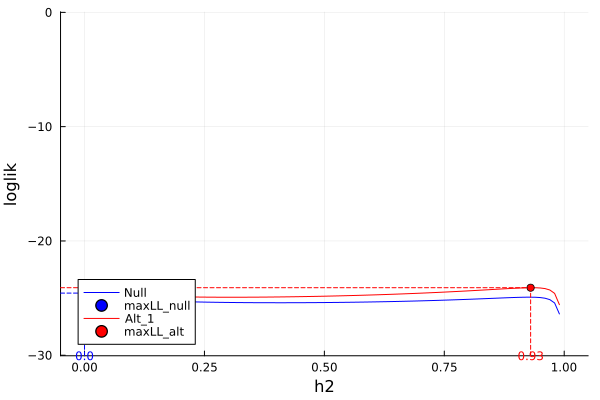

(sigma2_e = 0.9424184261036478, h2_null = 2.556751964474975e-16, lod = [0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873, 0.14752829300981873  …  0.4151525758615604, 0.06667066426725987, 0.2266740335756856, 0.2266740335756856, 0.09929425046903417, 0.013710982777837, 0.09929425046903417, 0.013710982777837, 0.08060830345161252, 0.08060830345161252])

In [208]:
test_a = scan(lpst_strains_y, geno_strains, kinship_strains;
               #weights = weights_true,
                prior_variance = 1.0, prior_sample_size = 0.1, 
                optim_interval = 10, plot_loglik = true, markerID = 1, h2_grid = grid_list, y_lims = [-30.0, -20.0])

In [71]:
test_a.h2_null

0.8329203388975025

In [72]:
@time test_A = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                  weights = weights_true, 
                                  prior_variance = 1.0, prior_sample_size = 0.1);

 11.092300 seconds (51.66 M allocations: 12.638 GiB, 6.61% gc time, 22.85% compilation time)


In [73]:
test_A.h2_null_list[lp_id]

0.48

In [74]:
findall(test_A.h2_null_list .>= 0.5)

1996-element Vector{Int64}:
    18
    37
    39
    42
    53
    58
    61
    67
    78
   123
   144
   191
   215
     ⋮
 32220
 32222
 32223
 32227
 32228
 32231
 32270
 32372
 32420
 32426
 32429
 32437

In [75]:
maximum(abs.(test_a.lod .- lod_by_hand.lod))

2.6928413624628664

In [76]:
scan_results_strains.h2_null

3.629255560717888e-16

In [77]:
@time test_A_exact = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                   weights = weights_true, 
                                   prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 10);

192.066706 seconds (2.81 G allocations: 486.444 GiB, 24.37% gc time, 0.16% compilation time)


In [78]:
test_A_exact.h2_null_list[lp_id]

0.47700360368597094

In [79]:
test_A.h2_null_list[lp_id]

0.48

In [80]:
hcat(test_A_exact.L[:, lp_id], test_a.lod, test_A.L[:, lp_id])

7321×3 Matrix{Float64}:
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.226185    0.289321   0.225985
 ⋮                      
 0.00849478  0.0190723  0.00827439
 0.00849478  0.0190723  0.00827439
 0.00849478  0.0190723  0.00827439
 0.147244    0.366897   0.148533
 0.49964     0.751512   0.501627
 0.49964     0.751512   0.501627
 0.469364    0.743515   0.47156
 0.256173    0.401996   0.257254
 0.469364    0.743515   0.47156
 0.256173    0.401996   0.257254
 0.284542    0.461123   0.285633
 0.284542    0.461123   0.285633

In [81]:
sum(abs.(test_A_exact.L[:, lp_id] .- test_a.lod))

612.4693881351816

In [82]:
maximum(abs.(test_A.L[:, lp_id] .- test_a.lod))

0.725066072163604

### Multiple-trait genome scans:

In [83]:
BLAS.set_num_threads(Threads.nthreads())

In [84]:
BLAS.get_num_threads()

16

In [85]:
grid_list = collect(0.0:0.01:0.99);

#### For individual liver proteome

In [86]:
size(lpst_ind_Y)

(248, 32445)

In [87]:
size(lpst_strains_Y)

(50, 32445)

In [88]:
Threads.nthreads()

16

In [89]:
@time bulkscan_results_ind_null = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

208.129944 seconds (2.67 G allocations: 1.887 TiB, 16.28% gc time)


In [90]:
BLAS.set_num_threads(Threads.nthreads())

In [91]:
@time bulkscan_results_ind_alt_grid = bulkscan_alt_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

103.137184 seconds (43.63 M allocations: 208.851 GiB, 1.56% gc time, 0.04% compilation time)


In [92]:
@time bulkscan_results_ind_null_grid = bulkscan_null_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

 18.150817 seconds (46.80 M allocations: 41.700 GiB, 3.90% gc time)


#### For liver proteome means by strains

In [93]:
@time bulkscan_results_strains_null = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                    prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

 98.629623 seconds (2.68 G allocations: 453.974 GiB, 27.05% gc time)


In [94]:
BLAS.set_num_threads(Threads.nthreads())

In [95]:
@time bulkscan_results_strains_alt_grid = bulkscan_alt_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list);

 71.670422 seconds (43.46 M allocations: 184.224 GiB, 3.12% gc time)


In [96]:
@time bulkscan_results_strains_null_grid = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                                              prior_variance = 1.0, prior_sample_size = 0.1);

  8.995208 seconds (43.67 M allocations: 11.769 GiB, 17.55% gc time)


In [97]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [98]:
bulkscan_results_strains_null_grid.L

7321×32445 Matrix{Float64}:
 0.545307  0.468929   0.20646     …  0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646     …  0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646     …  0.00117692  0.0641232  0.0190642
 0.545307  0.468929   0.20646        0.00117692  0.0641232  0.0190642
 0.241439  0.290214   0.23155        0.00717917  0.0387175  0.0620101
 ⋮                                ⋱                         
 

### Write-in results:

In [99]:
lp_names[lp_id]

"P42209_GLRPLDVAFLR_3"

In [100]:
output_folder_ind_nh = "BulkLMM_Outputs/Ind_NoHub";
output_folder_strains_nh = "BulkLMM_Outputs/Strains_NoHub";

In [101]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

#### Single_trait:

#### Multiple_traits:

In [102]:
b_ind_null = vcat(bulkscan_results_ind_null.h2_null_list', bulkscan_results_ind_null.L);

In [103]:
b_ind_null_grid = vcat(bulkscan_results_ind_null_grid.h2_null_list', bulkscan_results_ind_null_grid.L);

In [104]:
b_strains_null = vcat(bulkscan_results_strains_null.h2_null_list', bulkscan_results_strains_null.L);

In [105]:
b_strains_null_grid = vcat(bulkscan_results_strains_null_grid.h2_null_list', bulkscan_results_strains_null_grid.L);

In [106]:
b_strains_null_grid = vcat(bulkscan_results_strains_null_grid.h2_null_list', bulkscan_results_strains_null_grid.L);

## Examine loglikelihood:

In [107]:
findall(map(x -> (x <= 0.97) & (x >= 0.93), bulkscan_results_strains_null_grid.h2_null_list))

232-element Vector{Int64}:
    18
   123
   191
   290
   409
  1408
  2031
  2035
  2086
  2113
  2114
  2115
  2116
     ⋮
 30676
 30677
 30678
 30682
 30685
 31221
 31663
 32099
 32158
 32214
 32420
 32426

In [108]:
lp_id = 31663;

In [109]:
lp_id = 29437;

In [110]:
bulkscan_results_strains_null_grid.h2_null_list[lp_id]

0.0

In [111]:
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1)

50×1 Matrix{Float64}:
  0.723101667393456
 -0.005229579803751027
  0.5671044782774387
  0.8729002927035177
 -0.39874446384713513
  0.6649901317128264
 -0.4280034188751577
 -0.0155605194803013
  0.12261579869361594
  0.2814539962206704
  1.3658337001277736
  0.7530613924554537
 -0.5906494948086091
  ⋮
  1.1931594226767412
  0.30883098636353506
  1.482425733620314
 -0.7783282322660338
  0.7472071933054312
  1.2293177115446947
  0.0112999236787551
  0.7468628286495163
  1.0433607973666796
 -0.4533340882743783
 -0.3812757840304122
 -0.6036293933765857

In [112]:
## Inputs: Original data, a given h2 to evaluate loglik on
##         (optional) prior for regularization loglik near the upper boundary pt.
## Outputs: the logliks (null, alt mean model) under the given h2
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, 
               markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
end

function getLL(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1}, 
               markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    n = size(y0, 1);
    w = makeweights(h2, lambda0);

    X0_inter = reshape(X0[:, 1], :, 1);
    X_design = zeros(n, 2);
    X_design[:, 1] = X0[:, 1];
    X_design[:, 2] = X0[:, markerID+1];
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X_design, w, prior).ell)
end

getLL (generic function with 3 methods)

In [113]:
@time opt = optimize(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior).ll_null, 0.0, 1.0)

  0.578171 seconds (684.13 k allocations: 41.191 MiB, 43.82% gc time, 93.97% compilation time)


Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 1.000000e+00
 * Minimum: 2.433404e+01
 * Iterations: 36
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 37

In [114]:
@time gridopt = gridbrent(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior).ll_null, 0.0, 1.0, 10);

  0.726407 seconds (308.83 k allocations: 48.726 MiB, 34.76% gc time, 17.70% compilation time)


In [115]:
gridopt.minimizer

0.9999999816824213

In [116]:
@time ml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                     prior_variance = prior[1], prior_sample_size = prior[2]);

  0.094930 seconds (199.73 k allocations: 39.325 MiB, 13.03% gc time, 37.18% compilation time)


In [117]:
@time reml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                       reml = true, 
                       prior_variance = prior[1], prior_sample_size = prior[2]);

  0.092756 seconds (203.76 k allocations: 39.563 MiB, 12.61% gc time, 40.15% compilation time)


In [118]:
@time ml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                    reml = false, assumption = "alt", 
                    prior_variance = prior[1], prior_sample_size = prior[2]);

  2.018050 seconds (6.85 M allocations: 2.062 GiB, 10.54% gc time, 1.87% compilation time)


In [119]:
@time reml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                      reml = true, assumption = "alt",
                      prior_variance = prior[1], prior_sample_size = prior[2]);

  1.833922 seconds (6.32 M allocations: 1.920 GiB, 10.02% gc time)


In [120]:
opt.minimizer

0.999999984947842

In [121]:
opt.minimum

24.33403608624127

In [122]:
gridopt

(minimum = 24.334036103990684, minimizer = 0.9999999816824213)

In [123]:
prior

2-element Vector{Float64}:
 1.0
 0.0

In [124]:
prior = [1.0, 0.1];

In [125]:
@time begin
    ind_ll = map(x -> getLL(lpst_ind_y, geno_ind, kinship_ind_from_strains, 1997, x; prior = prior), h2_grid);
    strains_ll = map(x -> getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior), h2_grid);

    ind_ell_list2 = zeros(1000);
    ind_ell_list_alt2 = zeros(1000);
    strains_ell_list = zeros(1000);
    strains_ell_list_alt = zeros(1000);
    for k in 1:1000 
        ind_ell_list2[k] = ind_ll[k].ll_null;
        strains_ell_list[k] = strains_ll[k].ll_null;
        strains_ell_list_alt[k] = strains_ll[k].ll_markerID;
    end
end

LoadError: UndefVarError: h2_grid not defined

In [126]:
h2_grid = 0.001*collect(0:999);

In [127]:
@time begin
    ind_ell_list = zeros(1000);
    ind_ell_list_alt = zeros(1000);


    (lpst_ind_y0, geno_ind0, lambda_ind0) = transform_rotation(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                                              addIntercept = true);
    markerID = 1997;

    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(lpst_ind_y0, geno_ind0, lambda_ind0, markerID, curr_h2; prior = prior);
        ind_ell_list[k] = output.ll_null;
        ind_ell_list_alt[k] = output.ll_markerID;
    end
    
end

  0.152997 seconds (65.76 k allocations: 85.281 MiB, 17.40% gc time, 35.04% compilation time)


In [128]:
sum(ind_ell_list .- ind_ell_list2)

LoadError: UndefVarError: ind_ell_list2 not defined

In [129]:
ind_ell_list .- ind_ell_list_alt

1000-element Vector{Float64}:
 -1.3591185962713581
 -1.3551960536914294
 -1.3512723118882803
 -1.3473477895975776
 -1.3434228894584805
 -1.339497998655986
 -1.3355734895337719
 -1.3316497201807067
 -1.3277270349903603
 -1.3238057651968091
 -1.319886229386583
 -1.3159687339882566
 -1.312053573741025
  ⋮
 -0.0004418734557702919
 -0.0003997969494946574
 -0.0003586973674032379
 -0.0003185683166293529
 -0.0002794033529767148
 -0.0002411959802657293
 -0.00020393964987874824
 -0.00016762775968004462
 -0.00013225365324842642
 -9.781061930880242e-5
 -6.429189096479604e-5
 -3.1690644789250655e-5

In [130]:
gridopt.minimizer

0.9999999816824213

In [131]:
plot(collect(0.001:0.001:0.999), strains_ell_list, label = "Intercept", ylab = "loglik", xlab = "h2")
# plot!(collect(0.001:0.001:0.999), strains_ell_list_alt, label = "alt")
scatter!([opt.minimizer], [-opt.minimum], label = "brents_optim", color = "blue")
plot!([opt.minimizer, opt.minimizer], [-35.5, -opt.minimum], color = "blue", style = :dash, label = "")
plot!([-0.02, opt.minimizer], ones(2).* (-opt.minimum), color = "blue", style = :dash, label = "")
# scatter!([gridopt.minimizer], [-gridopt.minimum], label = "grid_brents_optim", color = "red")
# plot!([gridopt.minimizer, gridopt.minimizer], [-35.5, -gridopt.minimum], color = "red", style = :dash, label = "")
# plot!([-0.02, gridopt.minimizer], ones(2).* (-gridopt.minimum), color = "red", style = :dash, label = "")
annotate!(opt.minimizer, -35.5, 
          text("0.9275", :blue, :below, 8))
xlims!((-0.025, 1.05))
ylims!((-35.0, -24.0))

LoadError: UndefVarError: strains_ell_list not defined

In [132]:
min(1.0, 0.1)

0.1

In [133]:
min([1.0, 1.2, 3.0, 2.3])

LoadError: MethodError: no method matching min(::Vector{Float64})
[0mClosest candidates are:
[0m  min(::Any, [91m::Missing[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/base/missing.jl:134
[0m  min(::Any, [91m::Any[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/base/operators.jl:506
[0m  min(::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any...[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/base/operators.jl:655
[0m  ...

In [134]:
typeof(1.0:10.0)

StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

In [135]:
?ylims

search: ylims ylims!



```
ylims([plt])
```

Returns the y axis limits of the current plot or subplot


In [136]:
findmax(strains_ell_list)

LoadError: UndefVarError: strains_ell_list not defined

In [137]:
plot(collect(1:999).*0.001, ind_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP individuals", color = "blue", legend=:bottomleft)
plot!(collect(1:999).*0.001, strains_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP strain means", color = "red")

LoadError: UndefVarError: strains_ell_list not defined

## Examine hsqs, maxLods:

In [138]:
L_ind_null = bulkscan_results_ind_null.L;

In [139]:
L_ind_null_grid = bulkscan_results_ind_null_grid.L;

In [140]:
function getMaxLODs(L::Array{Float64, 2})
    
    m = size(L, 2);
    max_marker = Array{Int64, 1}(undef, m);
    max_lod = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        result_i = findmax(L[:, i]); 
        max_marker[i] = result_i[2];
        max_lod[i] = result_i[1];
    end
    
    return (max_markers = max_marker, max_lod = max_lod);
end

getMaxLODs (generic function with 1 method)

In [141]:
@time begin
    max_results_ind = getMaxLODs(L_ind_null);
    max_results_ind_grid = getMaxLODs(L_ind_null_grid);
end;

  3.075366 seconds (129.79 k allocations: 3.547 GiB, 9.47% gc time)


In [142]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [143]:
# CSV.write("output/max_results_ind.csv", DataFrame(round.(hcat(max_results_ind.max_markers, max_results_ind.max_lod), digits = 2), ["max_marker", "max_lod"]))

In [144]:
# CSV.write("output/max_results_ind_grid.csv", DataFrame(round.(hcat(max_results_ind_grid.max_markers, max_results_ind_grid.max_lod), digits = 2), ["max_marker", "max_lod"]))

In [145]:
@time bulkscan_results_ind_null_4 = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                  prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

551.405820 seconds (2.67 G allocations: 1.887 TiB, 69.43% gc time)


In [146]:
@time bulkscan_results_null_strains_4 = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                      prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

 96.616815 seconds (2.68 G allocations: 453.974 GiB, 25.81% gc time)


In [147]:
L_ind = bulkscan_results_ind_null.L;
L_strains = bulkscan_results_strains_null.L;
h2s_ind = bulkscan_results_ind_null.h2_null_list;
h2s_strains = bulkscan_results_strains_null.h2_null_list;

In [148]:
L_ind_4 = bulkscan_results_ind_null_4.L;
L_strains_4 = bulkscan_results_null_strains_4.L;
h2s_ind_4 = bulkscan_results_ind_null_4.h2_null_list;
h2s_strains_4 = bulkscan_results_null_strains_4.h2_null_list;

## Get Plot:

In [149]:
BXD_pmap = CSV.read("data/BXD_pmap.csv", DataFrame);
BXD_gmap = CSV.read("data/BXD_gmap.csv", DataFrame);

LoadError: ArgumentError: "data/BXD_pmap.csv" is not a valid file or doesn't exist

In [150]:
max_results_df_ind = CSV.read("output/max_results_ind.csv", DataFrame);

LoadError: ArgumentError: "output/max_results_ind.csv" is not a valid file or doesn't exist

In [151]:
max_results_df_ind_grid = CSV.read("output/max_results_ind_grid.csv", DataFrame);

LoadError: ArgumentError: "output/max_results_ind_grid.csv" is not a valid file or doesn't exist

In [152]:
using RecipesBase, Plots, Plots.PlotMeasures, ColorSchemes

LoadError: ArgumentError: Package RecipesBase not found in current path:
- Run `import Pkg; Pkg.add("RecipesBase")` to install the RecipesBase package.


In [153]:
function plot_eQTL2(lodc::Array{Float64, 2}, gmap::DataFrame, phenocovar::DataFrame;
                thr::Float64 = 5.0, kwargs...)
    
    x, y, z, mysteps, mychr = get_eQTL_accMb(
                                lodc, 
                                phenocovar,
                                gmap;
                                thr = thr,
                                kwargs...
                              )

    eQTLplot(x, y, z, mysteps, mychr, kwargs...)

end

plot_eQTL2 (generic function with 1 method)

In [154]:
BXD_pmap.Chr = convert.(String, BXD_pmap.Chr);

LoadError: UndefVarError: BXD_pmap not defined

In [155]:
BXD_gmap.Chr = convert.(String, BXD_gmap.Chr);

LoadError: UndefVarError: BXD_gmap not defined

In [156]:
plot_eQTL2(Matrix(max_results_df_ind), BXD_gmap, BXD_pmap)

LoadError: UndefVarError: max_results_df_ind not defined

In [157]:
lp_id

29437

In [158]:
lp_ind_y

248×1 Matrix{Float64}:
 14.925
 15.131
 15.074
 14.892
 14.935
 14.832
 15.292
 14.963
 14.944
 14.921
 14.983
 15.154
 14.923
  ⋮
 14.641
 14.851
 15.017
 14.991
 14.621
 14.943
 15.038
 14.799
 15.113
 14.788
 14.858
 14.921

In [159]:
lpst_ind_y

248×1 Matrix{Float64}:
  0.008839326301732115
  1.1520886987138745
  0.8357527073182789
 -0.17430256345361847
  0.06433686865183506
 -0.5072878175542362
  2.0455991305505488
  0.2197299872321194
  0.11428465676693068
 -0.013359690638316954
  0.33072507193233514
  1.2797330461191123
 -0.002260182168292419
  ⋮
 -1.5672908764412292
 -0.40184248708903764
  0.5194167159226832
  0.3751231058124136
 -1.6782859611414351
  0.1087349025319135
  0.6359615548579063
 -0.6904297073095867
  1.0521931224836834
 -0.7514770038946971
 -0.36299420744396654
 -0.013359690638316954

In [160]:
scan_results_ind_alt.lod

7321-element Vector{Float64}:
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.4486088396867715
 0.027257698423434687
 ⋮
 0.3258518530361997
 0.3258518530361997
 0.3258518530361997
 0.04951088178133477
 0.33876637614411703
 0.33876637614411703
 0.16359116385153535
 0.09563509438568
 0.16359116385153535
 0.09563509438568
 0.1615761938288365
 0.1615761938288365

### Heritabilities:

In [161]:
findall(abs.(h2s_strains .- h2s_strains_4) .>= 0.5)

Int64[]

In [162]:
findmax(abs.(h2s_strains .- h2s_strains_4))

(0.0, 1)

In [163]:
largest_h2diff_strains_y = reshape(lpst_strains_Y[:, 6], :, 1);

In [164]:
@time test_scan_results_opt1 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 1);

  0.115833 seconds (81.10 k allocations: 32.340 MiB, 63.66% gc time)


In [165]:
@time test_scan_results_opt2 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 2);

  0.304483 seconds (82.47 k allocations: 32.714 MiB, 86.98% gc time)


In [166]:
@time test_scan_results_opt4 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

  0.042282 seconds (83.84 k allocations: 33.088 MiB, 19.80% gc time)


In [167]:
@time test_scan_results_opt10 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 10);

  0.034196 seconds (87.97 k allocations: 34.217 MiB)


In [168]:
test_scan_results_opt1.h2_null

0.6582586920663421

In [169]:
test_scan_results_opt2.h2_null

7.258511121435776e-16

In [170]:
test_scan_results_opt4.h2_null

7.281068220985078e-16

In [171]:
test_scan_results_opt10.h2_null

7.556752351802334e-16

In [172]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.0)

(ll_null = -24.49493231706208, ll_markerID = -24.331720041707165)

In [173]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.66)

(ll_null = -24.962051098420524, ll_markerID = -24.678442130923703)

In [174]:
# ind_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x), collect(0.0:0.001:0.999));
l_strains_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x;
                              prior = [1.0, 0.1]), 
                   collect(0.0:0.001:0.999));

# ind_ell_list = zeros(999);
l_strains_ell_list = zeros(999);
l_strains_ell_list_alt = zeros(999);
for k in 1:999 
    # ind_ell_list[k] = ind_ll[k].ll_null;
    l_strains_ell_list[k] = l_strains_ll[k].ll_null;
    l_strains_ell_list_alt[k] = l_strains_ll[k].ll_markerID;
end

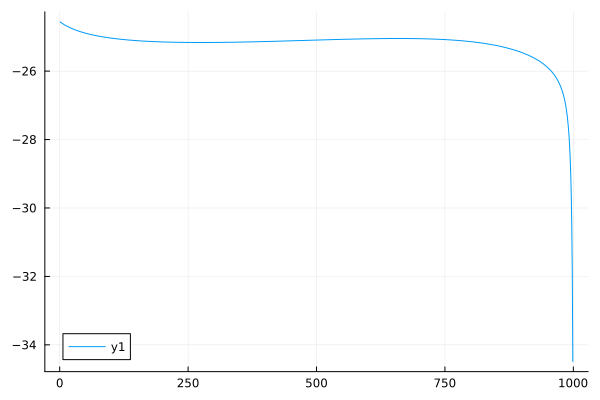

In [175]:
plot(l_strains_ell_list)

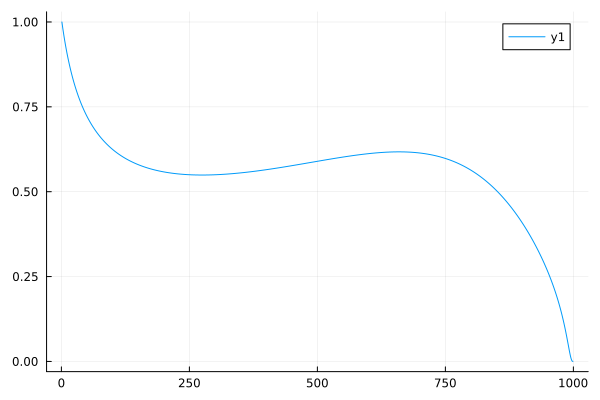

In [176]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

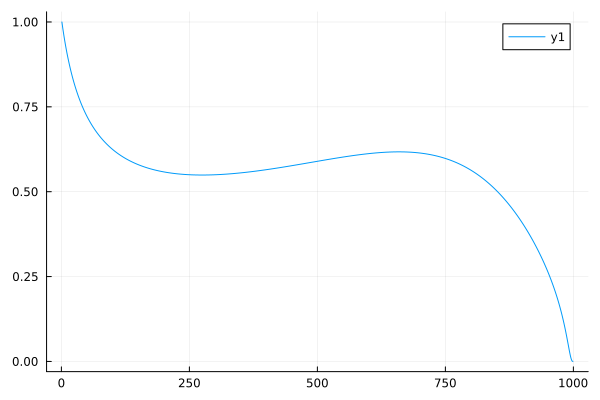

In [177]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

### Maximum lod scores:

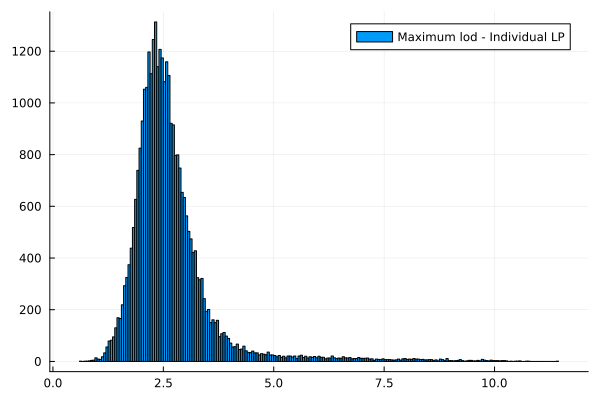

In [178]:
histogram(max_results_ind.max_lod, label = "Maximum lod - Individual LP")

In [179]:
histogram(max_results_strains.max_lod, label = "Maximum lod - Strain mean LP")

LoadError: UndefVarError: max_results_strains not defined

In [180]:
plot(max_results_ind.max_lod .- max_results_strains.max_lod, label = "Max lod: ind - strains")
hline!(x -> x = 0.0, label = "")

LoadError: UndefVarError: max_results_strains not defined

In [181]:
mean(max_results_ind.max_lod .- max_results_strains.max_lod .>= 0.0)

LoadError: UndefVarError: max_results_strains not defined

In [182]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

## Run GEMMA for single-trait scans:

In [183]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [184]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

"/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [185]:
run(`$gemma -h`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021

 type ./gemma -h [num] for detailed help
 options: 
  1: quick guide
  2: file I/O related
  3: SNP QC
  4: calculate relatedness matrix
  5: perform eigen decomposition
  6: perform variance component estimation
  7: fit a linear model
  8: fit a linear mixed model
  9: fit a multivariate linear mixed model
 10: fit a Bayesian sparse linear mixed model
 11: obtain predicted values
 12: calculate snp variance covariance
 13: note
 14: debug options

The GEMMA software is distributed under the GNU General Public v3
   -license    show license information
   see also http://www.xzlab.org/software.html, https://github.com/genetics-statistics


Process(`/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64 -h`, ProcessExited(0))

In [186]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

transform_bxd_pheno_to_gemma2 (generic function with 1 method)

In [187]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

transform_bxd_geno_to_gemma2 (generic function with 1 method)

In [188]:
lp_id

29437

In [189]:
# transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GEMMA_data/GN886_geno_strains_summary.txt", 2);
# transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GEMMA_data/GN886_geno_ind_summary.txt", 4);

In [190]:
lp_id = 29437;

In [191]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_strain_means_summary.csv", "data/GEMMA_data/GN886_pheno_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_summary.csv", "data/GEMMA_data/GN886_pheno_ind_summary.txt", lp_id);

LoadError: ArgumentError: "data/GN886_pheno_strain_means_summary.csv" is not a valid file or doesn't exist

In [192]:
# writedlm("data/GEMMA_data/kinship_strains.txt", kinship_strains, '\t')
# writedlm("data/GEMMA_data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [193]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [194]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

gemmaWrapper (generic function with 1 method)

In [195]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_strains_summary.txt", 
                   "data/GEMMA_data/GN886_geno_strains_summary.txt",
                   "data/GEMMA_data/kinship_strains.txt",
                   "results_strains.txt");

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
error! fail to open phenotype file: data/GEMMA_data/GN886_pheno_strains_summary.txt
error! fail to open mean genotype file: data/GEMMA_data/GN886_geno_strains_summary.txt
ERROR: Enforce failed for file_kin data/GEMMA_data/kinship_strains.txt: open file in src/param.cpp at line 934 in CheckParam


LoadError: failed process: Process(`[4m/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64[24m [4m-g[24m [4mdata/GEMMA_data/GN886_geno_strains_summary.txt[24m [4m-p[24m [4mdata/GEMMA_data/GN886_pheno_strains_summary.txt[24m [4m-k[24m [4mdata/GEMMA_data/kinship_strains.txt[24m [4m-lmm[24m [4m2[24m [4m-lmax[24m [4m1000000[24m [4m-o[24m [4mresults_strains.txt[24m`, ProcessSignaled(2)) [0]


In [196]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_ind_summary.txt", 
                   "data/GEMMA_data/GN886_geno_ind_summary.txt",
                   "data/GEMMA_data/kinship_ind.txt",
                   "results_ind.txt");

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
error! fail to open phenotype file: data/GEMMA_data/GN886_pheno_ind_summary.txt
error! fail to open mean genotype file: data/GEMMA_data/GN886_geno_ind_summary.txt
ERROR: Enforce failed for file_kin data/GEMMA_data/kinship_ind.txt: open file in src/param.cpp at line 934 in CheckParam


LoadError: failed process: Process(`[4m/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64[24m [4m-g[24m [4mdata/GEMMA_data/GN886_geno_ind_summary.txt[24m [4m-p[24m [4mdata/GEMMA_data/GN886_pheno_ind_summary.txt[24m [4m-k[24m [4mdata/GEMMA_data/kinship_ind.txt[24m [4m-lmm[24m [4m2[24m [4m-lmax[24m [4m1000000[24m [4m-o[24m [4mresults_ind.txt[24m`, ProcessSignaled(2)) [0]


In [197]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

198

In [198]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [199]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [200]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [201]:
hcat(gemma_ind_lod, scan_results_ind.lod, bulkscan_results_null_grid_ind.L[:, lp_id])

LoadError: UndefVarError: bulkscan_results_null_grid_ind not defined

In [202]:
hcat(gemma_strains_lod, scan_results_strains.lod, bulkscan_results_null_strains.L[:, lp_id])

LoadError: UndefVarError: bulkscan_results_null_strains not defined

In [203]:
lookRange = 1:7321

1:7321

In [204]:
plot(gemma_strains_lod[lookRange], label = "GEMMA_strains");
# plot!(scan_results_strains_alt_hub.lod[lookRange], label = "BulkLMM_strains")
plot!(bulkscan_results_null_strains.L[lookRange, lp_id], label = "BulkLMM_strains")

LoadError: UndefVarError: bulkscan_results_null_strains not defined

In [205]:
scan_results_ind.h2_null

3.392702346811808e-16